In [1]:
# 使用伪码表生成wave从而得到对比训练集，防止恒正运算
# server给subject提供一个伪码表，subject利用伪码表生成对应的对照集
# 伪码与最终的hash key或者BCH code无关
# 判别器需要保留一定的分辨能力
# data index range [2, 66]
import torch
import torch.nn as nn
from torch.nn import *
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.optim as optim


from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader

from preprocess import Process

In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [3]:
series = []

for num in range(2, 66):
    try:
        series += [Process(num).prepro(1024, 3)]
    except:
        print(f'subject {num} abandoned')

subject 13 abandoned
subject 16 abandoned
subject 17 abandoned
subject 18 abandoned
subject 20 abandoned
subject 26 abandoned


/home/dhz/anaconda3/lib/python3.9/site-packages/scipy/interpolate/fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/home/dhz/anaconda3/lib/python3.9/site-packages/numpy/ma/core.py:5244: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
/home/dhz/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


subject 42 abandoned
subject 47 abandoned
subject 48 abandoned
subject 50 abandoned


In [4]:
class MyDataset(Dataset):
    def __init__(self, series):
        self.series = series
        self.codes = []
        self.labels = np.zeros((len(self.series), len(self.series)))
        for i in range(len(self.series)):
            self.codes.append(np.random.rand(8))
            self.labels[i][i] = 1
            

    # need to overload
    def __len__(self):
        return len(self.series)

    # need to overload
    def __getitem__(self, idx):
        return torch.tensor(self.series[idx]), torch.tensor(self.codes[idx]), torch.tensor(self.labels[idx])

In [5]:
dataset = MyDataset(series)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=16,shuffle=True)

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.model1 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=2, padding='same'),
            nn.LeakyReLU(negative_slope=0.3),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=2, padding='same'),
            nn.LeakyReLU(negative_slope=0.3),
            nn.Conv1d(in_channels=32, out_channels=32, kernel_size=2, padding='same'),
            nn.LeakyReLU(negative_slope=0.3),
            nn.Conv1d(in_channels=32, out_channels=16, kernel_size=2, padding='same'),
            nn.LeakyReLU(negative_slope=0.3),
            nn.Conv1d(in_channels=16, out_channels=8, kernel_size=2, padding='same'),
            nn.LeakyReLU(negative_slope=0.3),
            nn.Conv1d(in_channels=8, out_channels=1, kernel_size=2, padding='same'),
            nn.LeakyReLU(negative_slope=0.3),
            nn.Sigmoid(),
            nn.Flatten(),
        )
        self.model2 = nn.Sequential(
            nn.Linear(1024, 1024, bias=True),
            nn.Sigmoid(),
        )
    def forward(self, input):
        x = self.model1(input)
        x = self.model2(x)
        return x

In [7]:
# Define the generator network
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim, bias=True)
        
    def forward(self, x):
        x = self.fc(x)
        return x

In [8]:
class ConvolutionBlock(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ConvolutionBlock, self).__init__()
        self.block = nn.Sequential(nn.Conv1d(input_size, hidden_size, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU()
        )
        
    def forward(self, x):
        x = self.block(x)
        return x

In [9]:
class TransformerClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers, num_heads, dropout, num_conv_blocks):
        super(TransformerClassifier, self).__init__()
        self.conv1 = ConvolutionBlock(input_size, hidden_size)
        self.conv_blocks = nn.ModuleList([
            ConvolutionBlock(hidden_size, hidden_size) for _ in range(num_conv_blocks)
        ])
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(hidden_size, num_heads, dim_feedforward=hidden_size, dropout=dropout),
            num_layers
        )
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        for conv_block in self.conv_blocks:
            x = conv_block(x)
        x = x.permute(0, 2, 1)  # Reshape to (batch_size, hidden_size, seq_len)
        x = self.transformer(x)
        x = x.mean(dim=1)  # Average the sequence dimension
        x = self.fc(x)
        return x

In [10]:
class RSBU_CW(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, down_sample=False):
        super().__init__()
        self.down_sample = down_sample
        self.in_channels = in_channels
        self.out_channels = out_channels
        stride = 1
        if down_sample:
            stride = 2
        self.BRC = nn.Sequential(
            nn.BatchNorm1d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride,
                      padding=1),
            nn.Dropout(p=0.3),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1,
                      padding=1),
            nn.Dropout(p=0.3)
        )
        self.global_average_pool = nn.AdaptiveAvgPool1d(1)
        self.FC = nn.Sequential(
            Linear(in_features=out_channels, out_features=out_channels),
            BatchNorm1d(out_channels),
            ReLU(inplace=True),
            Linear(in_features=out_channels, out_features=out_channels),
            Sigmoid()
        )
        self.flatten = Flatten()
        self.average_pool = AvgPool1d(kernel_size=1, stride=2)
 
    def forward(self, input):
        x = self.BRC(input)
        x_abs = torch.abs(x)
        gap = self.global_average_pool(x_abs)
        gap = self.flatten(gap)
        alpha = self.FC(gap)
        threshold = torch.mul(gap, alpha)
        threshold = torch.unsqueeze(threshold, 2)
        # 软阈值化
        sub = x_abs - threshold
        zeros = sub - sub
        n_sub = torch.max(sub, zeros)
        x = torch.mul(torch.sign(x), n_sub)  
        if self.down_sample:  # 如果是下采样，则对输入进行平均池化下采样
            input = self.average_pool(input)
        if self.in_channels != self.out_channels:  # 如果输入的通道和输出的通道不一致，则进行padding,直接通过复制拼接矩阵进行padding,原代码是通过填充0
            zero_padding=torch.zeros(input.shape).cuda()
            input = torch.cat((input, zero_padding), dim=1)
 
        result = x + input
        return result

In [11]:
class DRSNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv1d(in_channels=1, out_channels=4, kernel_size=3, stride=2, padding=1)
        self.bn = BatchNorm1d(16).double()
        self.relu = LeakyReLU(negative_slope=5e-2).double()
        self.softmax = Softmax(dim=1).double()
        self.global_average_pool = nn.AdaptiveAvgPool1d(1).double()
        self.flatten = Flatten()
        self.linear6_8 = Linear(in_features=256, out_features=128).double()
        self.linear8_4 = Linear(in_features=128, out_features=64).double()
        self.linear4_2 = Linear(in_features=64, out_features=32).double()
        self.output_center_pos = Linear(in_features=32, out_features=1)
        self.output_width = Linear(in_features=32, out_features=1)
 
        self.linear = Linear(in_features=16, out_features=8)
        self.output_class = Linear(in_features=8, out_features=3)
 
    def forward(self, input):  # 1*1024
        x = self.conv1(input)  # 4*512
        x = RSBU_CW(in_channels=4, out_channels=4, kernel_size=3, down_sample=True).double().cuda()(x)  # 4*256
        x = RSBU_CW(in_channels=4, out_channels=4, kernel_size=3, down_sample=False).double().cuda()(x)  # 4*256
        x = RSBU_CW(in_channels=4, out_channels=8, kernel_size=3, down_sample=True).double().cuda()(x)  # 8*128
        x = RSBU_CW(in_channels=8, out_channels=8, kernel_size=3, down_sample=False).double().cuda()(x)  # 8*128
        x = RSBU_CW(in_channels=8, out_channels=16, kernel_size=3, down_sample=True).double().cuda()(x)  # 16*64
        x = RSBU_CW(in_channels=16, out_channels=16, kernel_size=3, down_sample=False).double().cuda()(x)  # 16*64
        x = self.bn(x)
        x = self.relu(x)
        gap = self.global_average_pool(x)  # 16*1
        gap = self.flatten(gap)  # 1*16
        linear1 = self.linear(gap)  # 1*8
        output_class = self.output_class(linear1)  # 1*3
        output_class = self.softmax(output_class)  # 1*3
 
        return output_class

In [12]:
# Define the discriminator network
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

In [13]:
class ContinuityLoss(nn.Module):
    def __init__(self, weight=1.0):
        super(ContinuityLoss, self).__init__()
        self.weight = weight
        
    def forward(self, predictions):
        diff = predictions[:][1:] - predictions[:][:-1]
        loss = torch.mean(torch.abs(diff))
        return loss * self.weight

In [14]:
device='cuda' if torch.cuda.is_available() else 'cpu'

In [15]:
# Define the hyperparameters
input_dim = 8  # Dimension of the input noise vector
output_dim = 1024  # Dimension of the generated vector (ECG waveform)
lr = 0.001  # Learning rate
num_epochs = 50000
batch_size = 128

In [16]:
gen = Generator(input_dim, output_dim).to(device)
gen = gen.double()
dis = Discriminator(output_dim).to(device)
dis = dis.double()
cls = torch.load("classification")
cls = cls.double()

In [17]:
#训练器的优化器
d_optim = torch.optim.SGD(dis.parameters(), lr=2e-4, momentum=2e-3)
#训练生成器的优化器
g_optim = torch.optim.Adam(gen.parameters(),lr=2e-4)

In [18]:
#交叉熵损失函数
loss_fn = torch.nn.BCELoss()
continue_loss = ContinuityLoss(weight=5e2)
criterion = nn.CrossEntropyLoss()

In [19]:
D_loss = []
G_loss = []
C_acc = []

In [20]:
#训练循环
for epoch in range(20000):
    epoch_iterator = tqdm(dataloader, desc="Training Epoch %d" % (epoch + 1), ncols = 110)
    #初始化损失值
    g_epoch_loss = 0
    d_epoch_loss = 0
    count = len(dataloader) #返回批次数
    acc_num = 0
    num = 0
    #对数据集进行迭代
    for step, (subject, code, label) in enumerate(epoch_iterator):
        subject = torch.reshape(subject, (subject.size(0), 1, subject.size(1)))
        subject = subject.to(device) #把数据放到设备上
        code = code.to(device)
        code = torch.reshape(code, (code.size(0), 1, code.size(1)))
        label = label.to(device)
        size = subject.size(0) #img的第一位是size,获取批次的大小
        num += size
        
        #判别器训练(真实图片的损失和生成图片的损失),损失的构建和优化
        d_optim.zero_grad()#梯度归零
        #判别器对于真实图片产生的损失
        real_output = dis(subject) #判别器输入真实的图片，real_output对真实图片的预测结果
        d_real_loss = loss_fn(real_output,
                              torch.ones_like(real_output)
                              )
        d_real_loss.backward()#计算梯度
        
        #在生成器上去计算生成器的损失，优化目标是判别器上的参数
        gen_img = gen(code) #得到生成的图片
        #因为优化目标是判别器，所以对生成器上的优化目标进行截断
        fake_output = dis(gen_img.detach()) #判别器输入生成的图片，fake_output对生成图片的预测;detach会截断梯度，梯度就不会再传递到gen模型中了
        #判别器在生成图像上产生的损失
        d_fake_loss = loss_fn(fake_output,
                              torch.zeros_like(fake_output)
                              )
        d_fake_loss.backward()
        #判别器损失
        d_loss = d_real_loss + d_fake_loss
        #判别器优化
        d_optim.step()
        
        
        #生成器上损失的构建和优化
        g_optim.zero_grad() #先将生成器上的梯度置零
        fake_output = dis(gen_img)
        g_loss = loss_fn(fake_output,
                              torch.ones_like(fake_output)
                          ) + continue_loss(gen_img) # + criterion(class_output, label)
        g_loss.backward()
        g_optim.step()
        #累计每一个批次的loss
        with torch.no_grad():
            d_epoch_loss +=d_loss
            g_epoch_loss +=g_loss          
            
        epoch_iterator.set_postfix({'g_loss': '{0:1.5f}'.format(g_loss), "d_loss": '{0:1.5f}'.format(d_loss)})
        epoch_iterator.update(1)
    #求平均损失
    with torch.no_grad():
        d_epoch_loss /=count
        g_epoch_loss /=count
        D_loss.append(d_epoch_loss)
        G_loss.append(g_epoch_loss)

Training Epoch 146: 100%|█████████████████████| 4/4 [00:00<00:00, 153.99it/s, g_loss=50.22658, d_loss=0.80501]


Training Epoch 292: 100%|█████████████████████| 4/4 [00:00<00:00, 150.15it/s, g_loss=32.89547, d_loss=1.02485]


Training Epoch 438: 100%|██████████████████████| 4/4 [00:00<00:00, 166.44it/s, g_loss=8.27578, d_loss=1.19279]


Training Epoch 584: 100%|██████████████████████| 4/4 [00:00<00:00, 154.85it/s, g_loss=0.70093, d_loss=1.26630]


Training Epoch 730: 100%|██████████████████████| 4/4 [00:00<00:00, 160.52it/s, g_loss=0.57840, d_loss=1.30389]


Training Epoch 876: 100%|██████████████████████| 4/4 [00:00<00:00, 154.58it/s, g_loss=0.53230, d_loss=1.39778]


Training Epoch 1022: 100%|█████████████████████| 4/4 [00:00<00:00, 121.48it/s, g_loss=0.54709, d_loss=1.43898]


Training Epoch 1168: 100%|█████████████████████| 4/4 [00:00<00:00, 133.54it/s, g_loss=0.55013, d_loss=1.45080]


Training Epoch 1314: 100%|█████████████████████| 4/4 [00:00<00:00, 160.22it/s, g_loss=0.57881, d_loss=1.44556]


Training Epoch 1460: 100%|█████████████████████| 4/4 [00:00<00:00, 191.64it/s, g_loss=0.60445, d_loss=1.52271]


Training Epoch 1606: 100%|█████████████████████| 4/4 [00:00<00:00, 129.20it/s, g_loss=0.63956, d_loss=1.40854]


Training Epoch 1752: 100%|█████████████████████| 4/4 [00:00<00:00, 155.88it/s, g_loss=0.65833, d_loss=1.39616]


Training Epoch 1898: 100%|█████████████████████| 4/4 [00:00<00:00, 151.94it/s, g_loss=0.68637, d_loss=1.49831]


Training Epoch 2044: 100%|█████████████████████| 4/4 [00:00<00:00, 156.77it/s, g_loss=0.71967, d_loss=1.43771]


Training Epoch 2190: 100%|█████████████████████| 4/4 [00:00<00:00, 150.88it/s, g_loss=0.69638, d_loss=1.39012]


Training Epoch 2336: 100%|█████████████████████| 4/4 [00:00<00:00, 155.94it/s, g_loss=0.68558, d_loss=1.44111]


Training Epoch 2482: 100%|█████████████████████| 4/4 [00:00<00:00, 154.90it/s, g_loss=0.71942, d_loss=1.46709]


Training Epoch 2628: 100%|█████████████████████| 4/4 [00:00<00:00, 166.57it/s, g_loss=0.74383, d_loss=1.45368]


Training Epoch 2774: 100%|█████████████████████| 4/4 [00:00<00:00, 156.33it/s, g_loss=0.75616, d_loss=1.44949]


Training Epoch 2920: 100%|█████████████████████| 4/4 [00:00<00:00, 152.56it/s, g_loss=0.76250, d_loss=1.42460]


Training Epoch 3066: 100%|█████████████████████| 4/4 [00:00<00:00, 173.00it/s, g_loss=0.76506, d_loss=1.43484]


Training Epoch 3212: 100%|█████████████████████| 4/4 [00:00<00:00, 160.08it/s, g_loss=0.74580, d_loss=1.37765]


Training Epoch 3358: 100%|█████████████████████| 4/4 [00:00<00:00, 150.89it/s, g_loss=0.76971, d_loss=1.43777]


Training Epoch 3504: 100%|█████████████████████| 4/4 [00:00<00:00, 160.26it/s, g_loss=0.77956, d_loss=1.43144]


Training Epoch 3650: 100%|█████████████████████| 4/4 [00:00<00:00, 147.81it/s, g_loss=0.76303, d_loss=1.44365]


Training Epoch 3796: 100%|█████████████████████| 4/4 [00:00<00:00, 146.93it/s, g_loss=0.77500, d_loss=1.40786]


Training Epoch 3942: 100%|█████████████████████| 4/4 [00:00<00:00, 161.51it/s, g_loss=0.77829, d_loss=1.39328]


Training Epoch 4088: 100%|█████████████████████| 4/4 [00:00<00:00, 160.14it/s, g_loss=0.76752, d_loss=1.41139]


Training Epoch 4234: 100%|█████████████████████| 4/4 [00:00<00:00, 154.68it/s, g_loss=0.78107, d_loss=1.43095]


Training Epoch 4380: 100%|█████████████████████| 4/4 [00:00<00:00, 166.29it/s, g_loss=0.79408, d_loss=1.40155]


Training Epoch 4526: 100%|█████████████████████| 4/4 [00:00<00:00, 173.47it/s, g_loss=0.79675, d_loss=1.39315]


Training Epoch 4672: 100%|█████████████████████| 4/4 [00:00<00:00, 163.47it/s, g_loss=0.78540, d_loss=1.39944]


Training Epoch 4818: 100%|█████████████████████| 4/4 [00:00<00:00, 170.72it/s, g_loss=0.78122, d_loss=1.40838]


Training Epoch 4964: 100%|█████████████████████| 4/4 [00:00<00:00, 163.36it/s, g_loss=0.78829, d_loss=1.40054]


Training Epoch 5110: 100%|█████████████████████| 4/4 [00:00<00:00, 164.17it/s, g_loss=0.78772, d_loss=1.41935]


Training Epoch 5256: 100%|█████████████████████| 4/4 [00:00<00:00, 153.49it/s, g_loss=0.77848, d_loss=1.43252]


Training Epoch 5402: 100%|█████████████████████| 4/4 [00:00<00:00, 155.81it/s, g_loss=0.76849, d_loss=1.41068]


Training Epoch 5548: 100%|█████████████████████| 4/4 [00:00<00:00, 129.40it/s, g_loss=0.78922, d_loss=1.38528]


Training Epoch 5694: 100%|█████████████████████| 4/4 [00:00<00:00, 153.60it/s, g_loss=0.78957, d_loss=1.38678]


Training Epoch 5840: 100%|█████████████████████| 4/4 [00:00<00:00, 151.62it/s, g_loss=0.78120, d_loss=1.39852]


Training Epoch 5986: 100%|█████████████████████| 4/4 [00:00<00:00, 158.17it/s, g_loss=0.76955, d_loss=1.40074]


Training Epoch 6132: 100%|█████████████████████| 4/4 [00:00<00:00, 154.48it/s, g_loss=0.75547, d_loss=1.39600]


Training Epoch 6278: 100%|█████████████████████| 4/4 [00:00<00:00, 159.48it/s, g_loss=0.77508, d_loss=1.38555]


Training Epoch 6424: 100%|█████████████████████| 4/4 [00:00<00:00, 156.46it/s, g_loss=0.77157, d_loss=1.39028]


Training Epoch 6570: 100%|█████████████████████| 4/4 [00:00<00:00, 179.31it/s, g_loss=0.76115, d_loss=1.40407]


Training Epoch 6716: 100%|█████████████████████| 4/4 [00:00<00:00, 157.21it/s, g_loss=0.76780, d_loss=1.38877]


Training Epoch 6862: 100%|█████████████████████| 4/4 [00:00<00:00, 154.69it/s, g_loss=0.77439, d_loss=1.38711]


Training Epoch 7008: 100%|█████████████████████| 4/4 [00:00<00:00, 171.00it/s, g_loss=0.76473, d_loss=1.41141]


Training Epoch 7154: 100%|█████████████████████| 4/4 [00:00<00:00, 151.71it/s, g_loss=0.75334, d_loss=1.39673]


Training Epoch 7300: 100%|█████████████████████| 4/4 [00:00<00:00, 167.85it/s, g_loss=0.77459, d_loss=1.38735]


Training Epoch 7446: 100%|█████████████████████| 4/4 [00:00<00:00, 131.37it/s, g_loss=0.76065, d_loss=1.38885]


Training Epoch 7592: 100%|█████████████████████| 4/4 [00:00<00:00, 151.61it/s, g_loss=0.76024, d_loss=1.39266]


Training Epoch 7738: 100%|█████████████████████| 4/4 [00:00<00:00, 158.17it/s, g_loss=0.75940, d_loss=1.39192]


Training Epoch 7884: 100%|█████████████████████| 4/4 [00:00<00:00, 158.25it/s, g_loss=0.74132, d_loss=1.38703]


Training Epoch 8030: 100%|█████████████████████| 4/4 [00:00<00:00, 164.53it/s, g_loss=0.74990, d_loss=1.39258]


Training Epoch 8176: 100%|█████████████████████| 4/4 [00:00<00:00, 159.74it/s, g_loss=0.74863, d_loss=1.38612]


Training Epoch 8322: 100%|█████████████████████| 4/4 [00:00<00:00, 150.25it/s, g_loss=0.75890, d_loss=1.39456]


Training Epoch 8468: 100%|█████████████████████| 4/4 [00:00<00:00, 150.41it/s, g_loss=0.75345, d_loss=1.38678]


Training Epoch 8614: 100%|█████████████████████| 4/4 [00:00<00:00, 151.76it/s, g_loss=0.76330, d_loss=1.38642]


Training Epoch 8760: 100%|█████████████████████| 4/4 [00:00<00:00, 167.28it/s, g_loss=0.74657, d_loss=1.39182]


Training Epoch 8906: 100%|█████████████████████| 4/4 [00:00<00:00, 141.26it/s, g_loss=0.73728, d_loss=1.38617]


Training Epoch 9052: 100%|█████████████████████| 4/4 [00:00<00:00, 151.43it/s, g_loss=0.73591, d_loss=1.38867]


Training Epoch 9198: 100%|█████████████████████| 4/4 [00:00<00:00, 148.23it/s, g_loss=0.75126, d_loss=1.37874]


Training Epoch 9344: 100%|█████████████████████| 4/4 [00:00<00:00, 157.22it/s, g_loss=0.74233, d_loss=1.39315]


Training Epoch 9490: 100%|█████████████████████| 4/4 [00:00<00:00, 152.44it/s, g_loss=0.74844, d_loss=1.38390]


Training Epoch 9636: 100%|█████████████████████| 4/4 [00:00<00:00, 156.60it/s, g_loss=0.74285, d_loss=1.38699]


Training Epoch 9782: 100%|█████████████████████| 4/4 [00:00<00:00, 150.71it/s, g_loss=0.74831, d_loss=1.38761]


Training Epoch 9928: 100%|█████████████████████| 4/4 [00:00<00:00, 157.05it/s, g_loss=0.74011, d_loss=1.38586]


Training Epoch 10074: 100%|████████████████████| 4/4 [00:00<00:00, 162.24it/s, g_loss=0.73781, d_loss=1.38981]


Training Epoch 10220: 100%|████████████████████| 4/4 [00:00<00:00, 170.13it/s, g_loss=0.73652, d_loss=1.38687]


Training Epoch 10366: 100%|████████████████████| 4/4 [00:00<00:00, 153.76it/s, g_loss=0.74783, d_loss=1.38904]


Training Epoch 10512: 100%|████████████████████| 4/4 [00:00<00:00, 149.66it/s, g_loss=0.74763, d_loss=1.39085]


Training Epoch 10658: 100%|████████████████████| 4/4 [00:00<00:00, 150.45it/s, g_loss=0.74107, d_loss=1.38239]


Training Epoch 10804: 100%|████████████████████| 4/4 [00:00<00:00, 154.18it/s, g_loss=0.74051, d_loss=1.39090]


Training Epoch 10950: 100%|████████████████████| 4/4 [00:00<00:00, 155.90it/s, g_loss=0.74045, d_loss=1.38597]


Training Epoch 11096: 100%|████████████████████| 4/4 [00:00<00:00, 150.83it/s, g_loss=0.73804, d_loss=1.39512]


Training Epoch 11242: 100%|████████████████████| 4/4 [00:00<00:00, 167.80it/s, g_loss=0.73934, d_loss=1.38660]


Training Epoch 11388: 100%|████████████████████| 4/4 [00:00<00:00, 146.57it/s, g_loss=0.74299, d_loss=1.38526]


Training Epoch 11534: 100%|████████████████████| 4/4 [00:00<00:00, 153.23it/s, g_loss=0.73291, d_loss=1.39460]


Training Epoch 11680: 100%|████████████████████| 4/4 [00:00<00:00, 153.78it/s, g_loss=0.74183, d_loss=1.38076]


Training Epoch 11826: 100%|████████████████████| 4/4 [00:00<00:00, 147.34it/s, g_loss=0.73194, d_loss=1.39262]


Training Epoch 11972: 100%|████████████████████| 4/4 [00:00<00:00, 153.71it/s, g_loss=0.73352, d_loss=1.38474]


Training Epoch 12118: 100%|████████████████████| 4/4 [00:00<00:00, 156.12it/s, g_loss=0.73401, d_loss=1.38913]


Training Epoch 12264: 100%|████████████████████| 4/4 [00:00<00:00, 155.98it/s, g_loss=0.73207, d_loss=1.38587]


Training Epoch 12410: 100%|████████████████████| 4/4 [00:00<00:00, 158.13it/s, g_loss=0.73008, d_loss=1.38736]


Training Epoch 12556: 100%|████████████████████| 4/4 [00:00<00:00, 152.40it/s, g_loss=0.74012, d_loss=1.38834]


Training Epoch 12702: 100%|████████████████████| 4/4 [00:00<00:00, 150.65it/s, g_loss=0.72161, d_loss=1.38448]


Training Epoch 12848: 100%|████████████████████| 4/4 [00:00<00:00, 144.98it/s, g_loss=0.73227, d_loss=1.38696]


Training Epoch 12994: 100%|████████████████████| 4/4 [00:00<00:00, 157.34it/s, g_loss=0.73829, d_loss=1.38606]


Training Epoch 13140: 100%|████████████████████| 4/4 [00:00<00:00, 149.82it/s, g_loss=0.72940, d_loss=1.38776]


Training Epoch 13286: 100%|████████████████████| 4/4 [00:00<00:00, 145.16it/s, g_loss=0.73389, d_loss=1.38786]


Training Epoch 13432: 100%|████████████████████| 4/4 [00:00<00:00, 156.64it/s, g_loss=0.72780, d_loss=1.38726]


Training Epoch 13578: 100%|████████████████████| 4/4 [00:00<00:00, 154.58it/s, g_loss=0.73981, d_loss=1.38882]


Training Epoch 13724: 100%|████████████████████| 4/4 [00:00<00:00, 157.08it/s, g_loss=0.72479, d_loss=1.38853]


Training Epoch 13870: 100%|████████████████████| 4/4 [00:00<00:00, 147.61it/s, g_loss=0.73700, d_loss=1.38543]


Training Epoch 14016: 100%|████████████████████| 4/4 [00:00<00:00, 150.19it/s, g_loss=0.73948, d_loss=1.39527]


Training Epoch 14162: 100%|████████████████████| 4/4 [00:00<00:00, 152.52it/s, g_loss=0.73669, d_loss=1.38450]


Training Epoch 14308: 100%|████████████████████| 4/4 [00:00<00:00, 157.50it/s, g_loss=0.73955, d_loss=1.38540]


Training Epoch 14454: 100%|████████████████████| 4/4 [00:00<00:00, 155.75it/s, g_loss=0.73652, d_loss=1.38865]


Training Epoch 14600: 100%|████████████████████| 4/4 [00:00<00:00, 152.50it/s, g_loss=0.72566, d_loss=1.38073]


Training Epoch 14746: 100%|████████████████████| 4/4 [00:00<00:00, 152.97it/s, g_loss=0.72459, d_loss=1.38540]


Training Epoch 14892: 100%|████████████████████| 4/4 [00:00<00:00, 155.13it/s, g_loss=0.73629, d_loss=1.38835]


Training Epoch 15038: 100%|████████████████████| 4/4 [00:00<00:00, 137.27it/s, g_loss=0.72226, d_loss=1.37748]


Training Epoch 15184: 100%|████████████████████| 4/4 [00:00<00:00, 169.86it/s, g_loss=0.73794, d_loss=1.38770]


Training Epoch 15330: 100%|████████████████████| 4/4 [00:00<00:00, 152.65it/s, g_loss=0.73911, d_loss=1.39612]


Training Epoch 15476: 100%|████████████████████| 4/4 [00:00<00:00, 179.35it/s, g_loss=0.74245, d_loss=1.38201]


Training Epoch 15622: 100%|████████████████████| 4/4 [00:00<00:00, 154.17it/s, g_loss=0.73621, d_loss=1.38980]


Training Epoch 15768: 100%|████████████████████| 4/4 [00:00<00:00, 169.07it/s, g_loss=0.73866, d_loss=1.38772]


Training Epoch 15914: 100%|████████████████████| 4/4 [00:00<00:00, 172.56it/s, g_loss=0.73960, d_loss=1.38905]


Training Epoch 16060: 100%|████████████████████| 4/4 [00:00<00:00, 146.23it/s, g_loss=0.73455, d_loss=1.38583]


Training Epoch 16206: 100%|████████████████████| 4/4 [00:00<00:00, 154.90it/s, g_loss=0.72621, d_loss=1.38539]


Training Epoch 16352: 100%|████████████████████| 4/4 [00:00<00:00, 148.16it/s, g_loss=0.73926, d_loss=1.38691]


Training Epoch 16498: 100%|████████████████████| 4/4 [00:00<00:00, 147.35it/s, g_loss=0.75701, d_loss=1.38620]


Training Epoch 16644: 100%|████████████████████| 4/4 [00:00<00:00, 171.96it/s, g_loss=0.71918, d_loss=1.38220]


Training Epoch 16790: 100%|████████████████████| 4/4 [00:00<00:00, 178.64it/s, g_loss=0.73264, d_loss=1.38735]


Training Epoch 16936: 100%|████████████████████| 4/4 [00:00<00:00, 153.23it/s, g_loss=0.74115, d_loss=1.39169]


Training Epoch 17082: 100%|████████████████████| 4/4 [00:00<00:00, 153.68it/s, g_loss=0.72117, d_loss=1.39113]


Training Epoch 17228: 100%|████████████████████| 4/4 [00:00<00:00, 199.51it/s, g_loss=0.73185, d_loss=1.38412]


Training Epoch 17374: 100%|████████████████████| 4/4 [00:00<00:00, 155.12it/s, g_loss=0.73996, d_loss=1.38386]


Training Epoch 17520: 100%|████████████████████| 4/4 [00:00<00:00, 152.89it/s, g_loss=0.71501, d_loss=1.39650]


Training Epoch 17666: 100%|████████████████████| 4/4 [00:00<00:00, 147.96it/s, g_loss=0.73331, d_loss=1.38534]


Training Epoch 17812: 100%|████████████████████| 4/4 [00:00<00:00, 177.17it/s, g_loss=0.73491, d_loss=1.38036]


Training Epoch 17958: 100%|████████████████████| 4/4 [00:00<00:00, 176.25it/s, g_loss=0.72688, d_loss=1.39007]


Training Epoch 18104: 100%|████████████████████| 4/4 [00:00<00:00, 157.33it/s, g_loss=0.73243, d_loss=1.38181]


Training Epoch 18250: 100%|████████████████████| 4/4 [00:00<00:00, 172.74it/s, g_loss=0.75091, d_loss=1.38109]


Training Epoch 18396: 100%|████████████████████| 4/4 [00:00<00:00, 152.88it/s, g_loss=0.72223, d_loss=1.39112]


Training Epoch 18542: 100%|████████████████████| 4/4 [00:00<00:00, 164.78it/s, g_loss=0.75505, d_loss=1.38248]


Training Epoch 18688: 100%|████████████████████| 4/4 [00:00<00:00, 151.48it/s, g_loss=0.74428, d_loss=1.38617]


Training Epoch 18834: 100%|████████████████████| 4/4 [00:00<00:00, 153.52it/s, g_loss=0.72309, d_loss=1.39312]


Training Epoch 18980: 100%|████████████████████| 4/4 [00:00<00:00, 148.44it/s, g_loss=0.73404, d_loss=1.38824]


Training Epoch 19126: 100%|████████████████████| 4/4 [00:00<00:00, 153.48it/s, g_loss=0.74308, d_loss=1.38503]


Training Epoch 19272: 100%|████████████████████| 4/4 [00:00<00:00, 155.00it/s, g_loss=0.71935, d_loss=1.38977]


Training Epoch 19418: 100%|████████████████████| 4/4 [00:00<00:00, 156.64it/s, g_loss=0.73784, d_loss=1.38745]


Training Epoch 19564: 100%|████████████████████| 4/4 [00:00<00:00, 156.97it/s, g_loss=0.74301, d_loss=1.39171]


Training Epoch 19710: 100%|████████████████████| 4/4 [00:00<00:00, 157.90it/s, g_loss=0.74308, d_loss=1.39086]


Training Epoch 19856: 100%|████████████████████| 4/4 [00:00<00:00, 154.52it/s, g_loss=0.72826, d_loss=1.39207]


Training Epoch 20000: 100%|████████████████████| 4/4 [00:00<00:00, 155.77it/s, g_loss=0.72673, d_loss=1.39127]


In [21]:
d_real_loss

tensor(0.7057, device='cuda:0', dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyBackward0>)

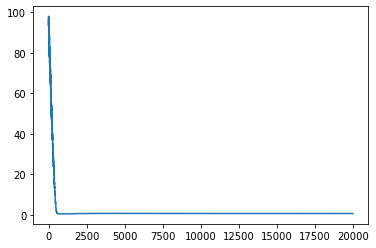

In [22]:
g_curve = [i.cpu() for i in G_loss]
plt.plot(g_curve)

In [23]:
code = dataset[0][1]

In [24]:
curve = gen(torch.randn(1, 8, device=device).double())

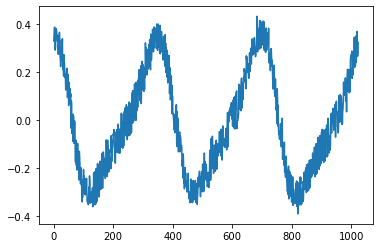

In [25]:
plt.plot(curve.tolist()[0])

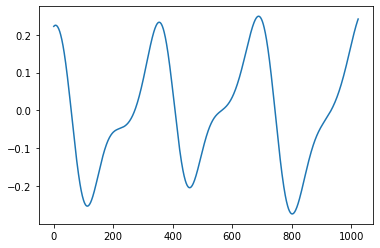

In [26]:
plt.plot(dataset[0][0])

In [27]:
continue_loss = ContinuityLoss(weight=2e5)

In [28]:
#训练循环
for epoch in range(10000):
    epoch_iterator = tqdm(dataloader, desc="Training Epoch %d" % (epoch + 1), ncols = 105)
    #初始化损失值
    g_epoch_loss = 0
    d_epoch_loss = 0
    count = len(dataloader) #返回批次数
    acc_num = 0
    num = 0
    #对数据集进行迭代
    for step, (subject, code, label) in enumerate(epoch_iterator):
        subject = torch.reshape(subject, (subject.size(0), 1, subject.size(1)))
        subject = subject.to(device) #把数据放到设备上
        code = code.to(device)
        code = torch.reshape(code, (code.size(0), 1, code.size(1)))
        label = label.to(device)
        size = subject.size(0) #img的第一位是size,获取批次的大小
        num += size
        
        #在生成器上去计算生成器的损失，优化目标是判别器上的参数
        gen_img = gen(code) #得到生成的图片
        
        class_output = cls(gen_img)
        for i in range(subject.size(0)):
            idx1 = torch.argmax(class_output[i])
            idx2 = torch.argmax(label[i])
            if idx1 == idx2:
                acc_num += 1
        
        
        
        #生成器上损失的构建和优化
        g_optim.zero_grad() #先将生成器上的梯度置零
        fake_output = dis(gen_img)
        g_loss = loss_fn(fake_output,
                              torch.ones_like(fake_output)
                          ) + continue_loss(gen_img) + 2e-10 * criterion(class_output, label)
        g_loss.backward()
        g_optim.step()
        #累计每一个批次的loss
        with torch.no_grad():
            g_epoch_loss +=g_loss          
            
        epoch_iterator.set_postfix({'g_loss': '{0:1.5f}'.format(g_loss), "acc": '{0:1.3f}'.format(acc_num / num)})
        epoch_iterator.update(1)
    #求平均损失
    with torch.no_grad():
        g_epoch_loss /=count
        G_loss.append(g_epoch_loss)
        acc = acc_num / num
        C_acc.append(acc)

Training Epoch 154: 100%|██████████████████████| 4/4 [00:00<00:00,  5.28it/s, g_loss=26.45667, acc=0.000]


Training Epoch 308: 100%|██████████████████████| 4/4 [00:00<00:00,  5.26it/s, g_loss=23.93927, acc=0.037]


Training Epoch 462: 100%|██████████████████████| 4/4 [00:00<00:00,  5.28it/s, g_loss=19.33996, acc=0.019]


Training Epoch 616: 100%|██████████████████████| 4/4 [00:00<00:00,  5.27it/s, g_loss=22.56821, acc=0.000]


Training Epoch 770: 100%|██████████████████████| 4/4 [00:00<00:00,  5.27it/s, g_loss=21.63055, acc=0.037]


Training Epoch 924: 100%|██████████████████████| 4/4 [00:00<00:00,  5.27it/s, g_loss=21.10788, acc=0.037]


Training Epoch 1078: 100%|█████████████████████| 4/4 [00:00<00:00,  5.27it/s, g_loss=16.03318, acc=0.000]


Training Epoch 1232: 100%|█████████████████████| 4/4 [00:00<00:00,  5.26it/s, g_loss=13.59947, acc=0.019]


Training Epoch 1386: 100%|█████████████████████| 4/4 [00:00<00:00,  5.26it/s, g_loss=12.91651, acc=0.019]


Training Epoch 1540: 100%|█████████████████████| 4/4 [00:00<00:00,  5.29it/s, g_loss=16.32859, acc=0.037]


Training Epoch 1694: 100%|█████████████████████| 4/4 [00:00<00:00,  5.27it/s, g_loss=15.50709, acc=0.000]


Training Epoch 1848: 100%|█████████████████████| 4/4 [00:00<00:00,  5.26it/s, g_loss=13.65254, acc=0.000]


Training Epoch 2002: 100%|█████████████████████| 4/4 [00:00<00:00,  5.26it/s, g_loss=13.73174, acc=0.037]


Training Epoch 2156: 100%|█████████████████████| 4/4 [00:00<00:00,  5.27it/s, g_loss=17.66121, acc=0.019]


Training Epoch 2310: 100%|█████████████████████| 4/4 [00:00<00:00,  5.24it/s, g_loss=15.37698, acc=0.000]


Training Epoch 2464: 100%|█████████████████████| 4/4 [00:00<00:00,  5.21it/s, g_loss=15.87080, acc=0.019]


Training Epoch 2597:   0%|                                                         | 0/4 [00:00<?, ?it/s]


KeyboardInterrupt: 

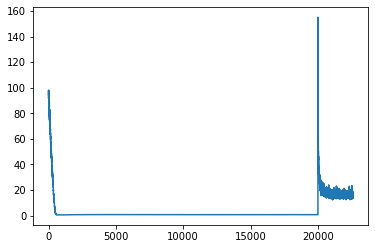

In [29]:
g_curve = [i.cpu() for i in G_loss]
plt.plot(g_curve)

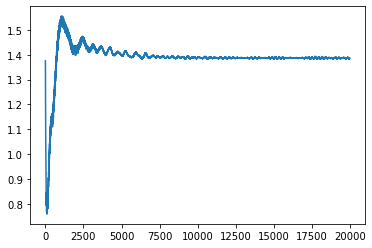

In [30]:
d_curve = [i.cpu() for i in D_loss]
plt.plot(d_curve)

In [ ]:
curve = gen(dataset[0][1].cuda()).cpu()

In [ ]:
plt.plot(curve.tolist())

In [ ]:
plt.plot(dataset[0][1])

In [ ]:
plt.plot(dataset[0][0])

In [ ]:
torch.save(gen, "generator")

In [ ]:
np.save('g_curve.npy', g_curve)
np.save('d_curve.npy', d_curve)

In [ ]:
np.save('dataset.npy', dataset)